In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


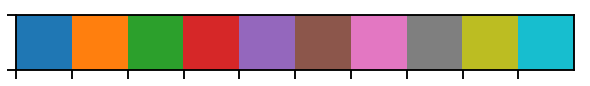

<IPython.core.display.Javascript object>

In [2]:
# import edward as ed
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import keras.backend as K
import edward as ed
%matplotlib inline
plt.style.use('seaborn-talk')
sns.set_context('talk', font_scale=1.4)
sess = ed.get_session()
sns.palplot(sns.color_palette())

In [3]:
df_fifa = pd.read_csv('data/fifa19/data.csv')
df_fifa.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


<IPython.core.display.Javascript object>

In [4]:
df_fifa.columns

Index([u'Unnamed: 0', u'ID', u'Name', u'Age', u'Photo', u'Nationality',
       u'Flag', u'Overall', u'Potential', u'Club', u'Club Logo', u'Value',
       u'Wage', u'Special', u'Preferred Foot', u'International Reputation',
       u'Weak Foot', u'Skill Moves', u'Work Rate', u'Body Type', u'Real Face',
       u'Position', u'Jersey Number', u'Joined', u'Loaned From',
       u'Contract Valid Until', u'Height', u'Weight', u'LS', u'ST', u'RS',
       u'LW', u'LF', u'CF', u'RF', u'RW', u'LAM', u'CAM', u'RAM', u'LM',
       u'LCM', u'CM', u'RCM', u'RM', u'LWB', u'LDM', u'CDM', u'RDM', u'RWB',
       u'LB', u'LCB', u'CB', u'RCB', u'RB', u'Crossing', u'Finishing',
       u'HeadingAccuracy', u'ShortPassing', u'Volleys', u'Dribbling', u'Curve',
       u'FKAccuracy', u'LongPassing', u'BallControl', u'Acceleration',
       u'SprintSpeed', u'Agility', u'Reactions', u'Balance', u'ShotPower',
       u'Jumping', u'Stamina', u'Strength', u'LongShots', u'Aggression',
       u'Interceptions', u'Positioning

<IPython.core.display.Javascript object>

In [5]:
df_fifa = df_fifa[[
    'ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value',
    'Wage', 'Special', 'Preferred Foot', 'International Reputation',
    'Weak Foot', 'Skill Moves', 'Position', 'Crossing', 'Finishing',
    'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
    'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
    'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina',
    'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning',
    'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle',
    'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning',
    'GKReflexes'
]]

<IPython.core.display.Javascript object>

In [6]:
df_fifa.Position.value_counts()

ST     2152
GK     2025
CB     1778
CM     1394
LB     1322
RB     1291
RM     1124
LM     1095
CAM     958
CDM     948
RCB     662
LCB     648
LCM     395
RCM     391
LW      381
RW      370
RDM     248
LDM     243
LS      207
RS      203
RWB      87
LWB      78
CF       74
RAM      21
LAM      21
RF       16
LF       15
Name: Position, dtype: int64

<IPython.core.display.Javascript object>

In [7]:
df_sel = df_fifa[df_fifa != 'GK']


def recategorize(x):
    if x in [
        'LF', 'RF', 'CF', 'ST', 'RS', 'LS', 'LW', 'RW', 'CAM', 'LAM', 'RAM',
        'LM', 'RM'
    ]:
        return 0
    elif x in ['LDM', 'RDM', 'LCM', 'RCM', 'CDM', 'CM']:
        return 1
    else:
        return 2


df_sel['pos'] = df_sel['Position'].apply(recategorize)
df_sel.pos.value_counts()

/home/a635137/pplenv/local/lib/python2.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


2    7951
0    6637
1    3619
Name: pos, dtype: int64

<IPython.core.display.Javascript object>

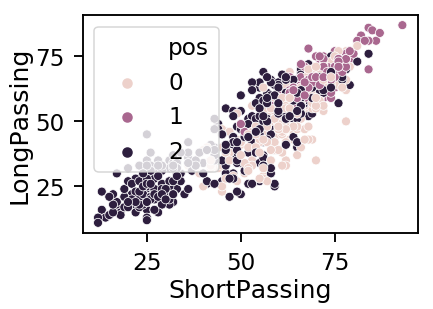

<IPython.core.display.Javascript object>

In [8]:
sns.scatterplot(
    x='ShortPassing', y='LongPassing', hue='pos', data=df_sel.sample(n=1000)
)

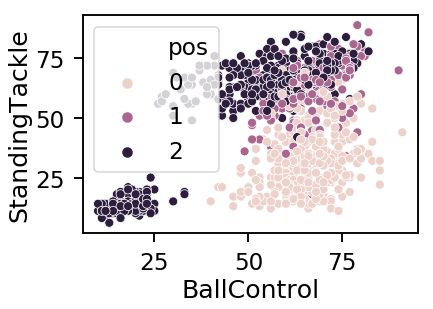

<IPython.core.display.Javascript object>

In [9]:
sns.scatterplot(
    x='BallControl', y='StandingTackle', hue='pos', data=df_sel.sample(n=1000)
)

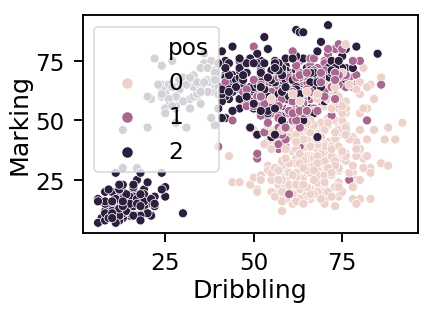

<IPython.core.display.Javascript object>

In [10]:
sns.scatterplot(
    x='Dribbling', y='Marking', hue='pos', data=df_sel.sample(n=1000)
)

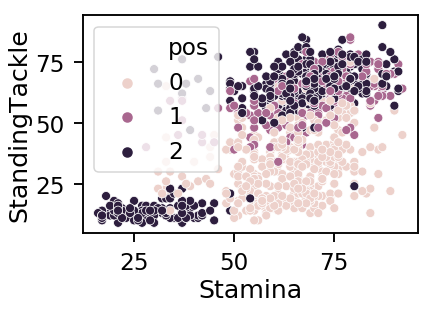

<IPython.core.display.Javascript object>

In [11]:
sns.scatterplot(
    x='Stamina', y='StandingTackle', hue='pos', data=df_sel.sample(n=1000)
)

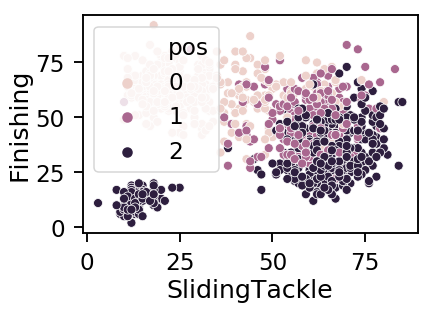

<IPython.core.display.Javascript object>

In [12]:
sns.scatterplot(
    x='SlidingTackle', y='Finishing', hue='pos', data=df_sel.sample(n=1000)
)

## Ball Control vs Standing Tackle

In [13]:
df_ml = df_sel[['BallControl', 'StandingTackle', 'pos']]
df_ml = df_ml.dropna()
df_ml.head()

,BallControl,StandingTackle,pos
0,96.0,28.0,0
1,94.0,31.0,0
2,95.0,24.0,0
3,42.0,21.0,2
4,91.0,58.0,1


<IPython.core.display.Javascript object>

In [14]:
train, test = train_test_split(df_ml, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

(11621, 'train examples')
(2906, 'validation examples')
(3632, 'test examples')


<IPython.core.display.Javascript object>

In [15]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(df):
    df = df.copy()
    X = df.drop(['pos'], axis=1)
    X = np.array(X)
    labels = np_utils.to_categorical(df['pos'])
    return X, labels

<IPython.core.display.Javascript object>

In [16]:
train_x, train_y = df_to_dataset(train)
val_x, val_y = df_to_dataset(val)
test_x, test_y = df_to_dataset(test)

<IPython.core.display.Javascript object>

In [17]:
input_dim = len(df_ml.columns) - 1
epochs = 10

model = Sequential()
model.add(Dense(5, input_dim=input_dim, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='softmax'))

sgd = optimizers.SGD(
    lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True, clipvalue=0.7
)
model.compile(
    optimizer=sgd,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    #     run_eagerly=True
)

model.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
    epochs=epochs,
    batch_size=4
)

Train on 11621 samples, validate on 2906 samples
Epoch 1/10
11621/11621 [==============================] - 4s 341us/step - loss: 0.6757 - acc: 0.7403 - val_loss: 0.5271 - val_acc: 0.7959
Epoch 2/10
11621/11621 [==============================] - 4s 317us/step - loss: 0.5345 - acc: 0.7947 - val_loss: 0.6090 - val_acc: 0.7784
Epoch 3/10
11621/11621 [==============================] - 4s 318us/step - loss: 0.5321 - acc: 0.7905 - val_loss: 0.4935 - val_acc: 0.8025
Epoch 4/10
11621/11621 [==============================] - 4s 324us/step - loss: 0.5227 - acc: 0.7951 - val_loss: 0.5717 - val_acc: 0.7825
Epoch 5/10
11621/11621 [==============================] - 4s 343us/step - loss: 0.5332 - acc: 0.7893 - val_loss: 0.5336 - val_acc: 0.7894
Epoch 6/10
11621/11621 [==============================] - 4s 325us/step - loss: 0.5660 - acc: 0.7924 - val_loss: 0.5171 - val_acc: 0.7849
Epoch 7/10
11621/11621 [==============================] - 4s 317us/step - loss: 0.5673 - acc: 0.7884 - val_loss: 0.5116 - v

<IPython.core.display.Javascript object>

In [18]:
loss, accuracy = model.evaluate(test_x, test_y)
print("Accuracy", accuracy)

3632/3632 [==============================] - 0s 18us/step
('Accuracy', 0.7984581497797357)


<IPython.core.display.Javascript object>

In [19]:
def plot_decision_boundary(clf, X, Y, cmap='Paired_r'):
    h = 0.5
    x_min, x_max = X[:, 0].min() - 10 * h, X[:, 0].max() + 10 * h
    y_min, y_max = X[:, 1].min() - 10 * h, X[:, 1].max() + 10 * h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, edgecolors='k')

<IPython.core.display.Javascript object>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 18        
Total params: 473
Trainable params: 473
Non-trainable params: 0
_________________________________________________________________
None
('Learn

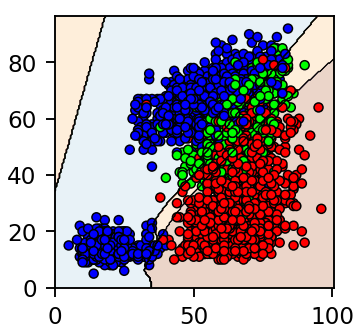

<IPython.core.display.Javascript object>

In [20]:
print(model.summary())
print('Learning rate', K.eval(model.optimizer.lr))
print('Momentum', K.eval(model.optimizer.momentum))
print('clipvalue', model.optimizer.clipvalue)
print('accuracy', accuracy)
print('epochs', epochs)
plot_decision_boundary(model, test_x, test_y)

## Edward

In [21]:
from edward.models import Normal, Categorical
from collections import Counter

<IPython.core.display.Javascript object>

In [23]:
(train_x.shape, train_y.shape)

((11621, 2), (11621, 3))

<IPython.core.display.Javascript object>

In [32]:
W_0 = Normal(loc=tf.zeros([2, 5]), scale=tf.ones([2, 5]))
W_1 = Normal(loc=tf.zeros([5, 3]), scale=tf.ones([5, 3]))
# W_2 = Normal(loc=tf.zeros([10, 15]), scale=tf.ones([10, 15]))
# W_3 = Normal(loc=tf.zeros([15, 10]), scale=tf.ones([15, 10]))
# W_4 = Normal(loc=tf.zeros([10, 5]), scale=tf.ones([10, 5]))
# W_5 = Normal(loc=tf.zeros([10, 3]), scale=tf.ones([10, 3]))
b_0 = Normal(loc=tf.zeros(5), scale=tf.ones(5))
b_1 = Normal(loc=tf.zeros(3), scale=tf.ones(3))
# b_2 = Normal(loc=tf.zeros(15), scale=tf.ones(15))
# b_3 = Normal(loc=tf.zeros(10), scale=tf.ones(10))
# b_4 = Normal(loc=tf.zeros(5), scale=tf.ones(5))
# b_5 = Normal(loc=tf.zeros(3), scale=tf.ones(3))

x = np.float32(train_x)
y = Categorical(tf.matmul(tf.matmul(x, W_0) + b_0, W_1) + b_1, dtype=tf.int32)

<IPython.core.display.Javascript object>

In [25]:
# tf.reset_default_graph()

qW_0 = Normal(
    loc=tf.get_variable("qW_0/loc", [2, 5]),
    scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [2, 5]))
)
qb_0 = Normal(
    loc=tf.get_variable("qb_0", [5]),
    scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [5]))
)

qW_1 = Normal(
    loc=tf.get_variable("qW_1/loc", [5, 3]),
    scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [5, 3]))
)
qb_1 = Normal(
    loc=tf.get_variable("qb_1", [3]),
    scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [3]))
)

<IPython.core.display.Javascript object>

In [33]:
inference = ed.KLqp(
    {
        W_0: qW_0,
        b_0: qb_0,
        W_1: qW_1,
        b_1: qb_1
    },
    data={y: tf.convert_to_tensor(np.argmax(train_y, axis=1), dtype=tf.int32)}
)
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: 9719.577


<IPython.core.display.Javascript object>

In [34]:
prob_lst, samples = [], []
w0_samples, b0_samples, w1_samples, b1_samples = [], [], [], []
w2_samples, b2_samples, w3_samples, b3_samples = [], [], [], []
w4_samples, b4_samples, w5_samples, b5_samples = [], [], [], []
n = 50
for _ in range(n):
    w0_samp = qW_0.sample()
    b0_samp = qb_0.sample()
    w1_samp = qW_1.sample()
    b1_samp = qb_1.sample()
    #     w2_samp = qW_2.sample()
    #     b2_samp = qb_2.sample()
    #     w3_samp = qW_3.sample()
    #     b3_samp = qb_3.sample()
    #     w4_samp = qW_4.sample()
    #     b4_samp = qb_4.sample()
    #     w5_samp = qW_5.sample()
    #     b5_samp = qb_5.sample()

    w0_samples.append(w0_samp.eval())
    b0_samples.append(b0_samp.eval())
    w1_samples.append(w1_samp.eval())
    b1_samples.append(b1_samp.eval())
    #     w2_samples.append(w2_samp.eval())
    #     b2_samples.append(b2_samp.eval())
    #     w3_samples.append(w3_samp.eval())
    #     b3_samples.append(b3_samp.eval())
    #     w4_samples.append(w4_samp.eval())
    #     b4_samples.append(b4_samp.eval())
    #     w5_samples.append(w5_samp.eval())
    #     b5_samples.append(b5_samp.eval())

    prob = tf.nn.softmax(
        tf.matmul(tf.matmul(np.float32(test_x), w0_samp) + b0_samp, w1_samp) +
        b1_samp
    )
    prob_lst.append(np.argmax(prob.eval(), axis=1))

<IPython.core.display.Javascript object>

In [35]:
prob_lst = np.array(prob_lst)
common_preds = []
for i in range(prob_lst.shape[1]):
    count = Counter(prob_lst[:, i])
    common_preds.append(count.most_common(1)[0][0])

<IPython.core.display.Javascript object>

In [36]:
res = np.argmax(test_y, axis=1) - np.array(common_preds)
acc = res[res == 0].shape[0] * 100.0 / res.shape[0]
print("Accuracy: {0}%".format(acc))

Accuracy: 78.9922907489%


<IPython.core.display.Javascript object>

In [37]:
# Weights
def plot_decision_boundary_prob(X, Y, n, cmap='Paired_r'):
    h = 0.5
    x_min, x_max = X[:, 0].min() - 10 * h, X[:, 0].max() + 10 * h
    y_min, y_max = X[:, 1].min() - 10 * h, X[:, 1].max() + 10 * h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    prob_lst = []
    for _ in range(n):
        w0_samp = qW_0.sample()
        b0_samp = qb_0.sample()
        w1_samp = qW_1.sample()
        b1_samp = qb_1.sample()
        #     w2_samp = qW_2.sample()
        #     b2_samp = qb_2.sample()
        #     w3_samp = qW_3.sample()
        #     b3_samp = qb_3.sample()
        #     w4_samp = qW_4.sample()
        #     b4_samp = qb_4.sample()
        #     w5_samp = qW_5.sample()
        #     b5_samp = qb_5.sample()

        w0_samples.append(w0_samp.eval())
        b0_samples.append(b0_samp.eval())
        w1_samples.append(w1_samp.eval())
        b1_samples.append(b1_samp.eval())
        #     w2_samples.append(w2_samp.eval())
        #     b2_samples.append(b2_samp.eval())
        #     w3_samples.append(w3_samp.eval())
        #     b3_samples.append(b3_samp.eval())
        #     w4_samples.append(w4_samp.eval())
        #     b4_samples.append(b4_samp.eval())
        #     w5_samples.append(w5_samp.eval())
        #     b5_samples.append(b5_samp.eval())

        prob = tf.nn.softmax(
            tf.matmul(
                tf.matmul(np.float32(np.c_[xx.ravel(), yy.ravel()]), w0_samp) +
                b0_samp, w1_samp
            ) + b1_samp
        )
        prob_lst.append(np.argmax(prob.eval(), axis=1))
    prob_lst = np.array(prob_lst)
    common_preds = []
    for i in range(prob_lst.shape[1]):
        count = Counter(prob_lst[:, i])
        common_preds.append(count.most_common(1)[0][0])
    plt.figure(figsize=(5, 5))
    plt.contourf(
        xx, yy, np.array(common_preds).reshape(xx.shape), cmap=cmap, alpha=0.25
    )
    plt.contour(
        xx,
        yy,
        np.array(common_preds).reshape(xx.shape),
        colors='k',
        linewidths=0.7
    )
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, edgecolors='k')

<IPython.core.display.Javascript object>

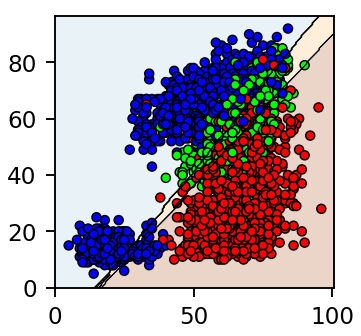

<IPython.core.display.Javascript object>

In [38]:
plot_decision_boundary_prob(test_x, test_y, n)